In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

In [2]:
import geopandas as gpd

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
gdf = gpd.read_file('../data/external/Area_Estudio/Area_Elevaciones_v2.geojson')
gdf

,geometry
0,"POLYGON ((-103.47743 20.63258, -103.47630 20.6..."


In [4]:
# Reads mun_gdf GeoDataFrame as polygon
poly = gdf.geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

In [5]:
n = 20.742277
s = 20.611211
e = -103.262616
w = -103.407605

In [5]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

In [6]:
time_of_interest = "2021-05-01/2021-10-31"

In [11]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 20}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 11 Items


In [12]:
for i in items:
    print(
    f"data {i.id} from {i.datetime.date()}"
    + f" with {i.properties['eo:cloud_cover']}% cloud cover"
)

data S2B_MSIL2A_20211014T172259_R012_T13QFC_20211015T055251 from 2021-10-14 with 1.974586% cloud cover
data S2A_MSIL2A_20211009T172231_R012_T13QFC_20211010T051709 from 2021-10-09 with 17.622135% cloud cover
data S2B_MSIL2A_20210924T171949_R012_T13QFC_20210925T155931 from 2021-09-24 with 12.205291% cloud cover
data S2B_MSIL2A_20210726T171859_R012_T13QFC_20210727T041647 from 2021-07-26 with 7.240388% cloud cover
data S2B_MSIL2A_20210616T171859_R012_T13QFC_20210617T051237 from 2021-06-16 with 8.024542% cloud cover
data S2B_MSIL2A_20210606T171859_R012_T13QFC_20210609T213440 from 2021-06-06 with 6.488263% cloud cover
data S2B_MSIL2A_20210527T171859_R012_T13QFC_20210528T105514 from 2021-05-27 with 5.092631% cloud cover
data S2A_MSIL2A_20210522T171901_R012_T13QFC_20210523T033207 from 2021-05-22 with 5.143573% cloud cover
data S2B_MSIL2A_20210517T171859_R012_T13QFC_20210520T071706 from 2021-05-17 with 5.381439% cloud cover
data S2B_MSIL2A_20210507T171849_R012_T13QFC_20210509T004826 from 2021-0

In [10]:
selected_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing S2B_MSIL2A_20211014T172259_R012_T13QFC_20211015T055251 from 2021-10-14 with 1.974586% cloud cover


In [11]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [12]:
selected_item

<Item id=S2B_MSIL2A_20211014T172259_R012_T13QFC_20211015T055251>

In [13]:
asset_hrefs = [
    find_asset_by_band_common_name(selected_item, "red").href,
    find_asset_by_band_common_name(selected_item, "green").href,
    find_asset_by_band_common_name(selected_item, "blue").href,
]

In [14]:
signed_hrefs = [pc.sign(asset_href) for asset_href in asset_hrefs]

In [15]:
asset_hrefs

['https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/Q/FC/2021/10/14/S2B_MSIL2A_20211014T172259_N0300_R012_T13QFC_20211015T055251.SAFE/GRANULE/L2A_T13QFC_A024062_20211014T173544/IMG_DATA/R10m/T13QFC_20211014T172259_B04_10m.tif',
 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/Q/FC/2021/10/14/S2B_MSIL2A_20211014T172259_N0300_R012_T13QFC_20211015T055251.SAFE/GRANULE/L2A_T13QFC_A024062_20211014T173544/IMG_DATA/R10m/T13QFC_20211014T172259_B03_10m.tif',
 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/Q/FC/2021/10/14/S2B_MSIL2A_20211014T172259_N0300_R012_T13QFC_20211015T055251.SAFE/GRANULE/L2A_T13QFC_A024062_20211014T173544/IMG_DATA/R10m/T13QFC_20211014T172259_B02_10m.tif']

In [16]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image


def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)

In [17]:
bands = [read_band(href) for href in signed_hrefs]

In [24]:
from shapely.geometry import Point

def raster_to_poly(href):

    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        val = ds.read(1, window=aoi_window)
        no_data=ds.nodata
        geometry = [Point(ds.xy(x,y)[0],ds.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
        v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
        df = gpd.GeoDataFrame({'geometry':geometry,'data':v})
        df.crs = ds.crs
        
        return df

In [24]:
print(df.shape)
df.head(5)

(38544, 2)


,geometry,data
0,POINT (600005.000 2300035.000),321
1,POINT (600015.000 2300035.000),328
2,POINT (600025.000 2300035.000),366
3,POINT (600035.000 2300035.000),357
4,POINT (600045.000 2300035.000),343


<AxesSubplot:>

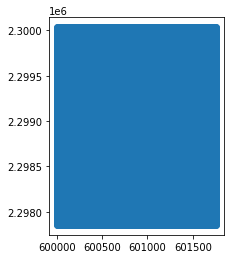

In [23]:
df.plot()

In [23]:
href_0 = signed_hrefs[2]

In [20]:
from shapely.geometry import Point

with rasterio.open(href_0) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    val = ds.read(1, window=aoi_window)
    no_data=ds.nodata
    geometry = [Point(ds.xy(x,y)[0],ds.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != no_data]
    df = gpd.GeoDataFrame({'geometry':geometry,'data':v})
    df.crs = ds.crs

In [21]:
val

array([[ 619,  632,  628, ..., 1440, 1272, 1770],
       [ 597,  619,  645, ..., 1790, 1404, 1384],
       [ 596,  569,  597, ..., 1558, 1426, 1528],
       ...,
       [ 848, 1120, 1602, ...,  687,  763,  698],
       [1248, 1900, 1548, ...,  899,  861,  807],
       [1048, 1240, 1156, ...,  918,  891,  996]], dtype=uint16)

In [48]:
aoi_window

Window(col_off=6579.4238977794885, row_off=10540.32950162352, width=1525.4464685989515, height=1466.4554182041902)

In [41]:
bands[0].shape

(439, 1525)

In [18]:
rasterio.open(signed_hrefs[0])

<open DatasetReader name='https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/Q/FD/2021/05/27/S2B_MSIL2A_20210527T171859_N0212_R012_T13QFD_20210528T114847.SAFE/GRANULE/L2A_T13QFD_A022060_20210527T172618/IMG_DATA/R10m/T13QFD_20210527T171859_B04_10m.tif?st=2022-02-16T17%3A35%3A54Z&se=2022-02-17T18%3A20%3A54Z&sp=rl&sv=2020-06-12&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-02-17T16%3A35%3A54Z&ske=2022-02-18T17%3A35%3A54Z&sks=b&skv=2020-06-12&sig=12ZUCYukNJYP4dLt7Iv3KQVCHpmKJsT4VUswe1IN9gI%3D' mode='r'>

In [19]:
multiband_data = np.stack(bands)

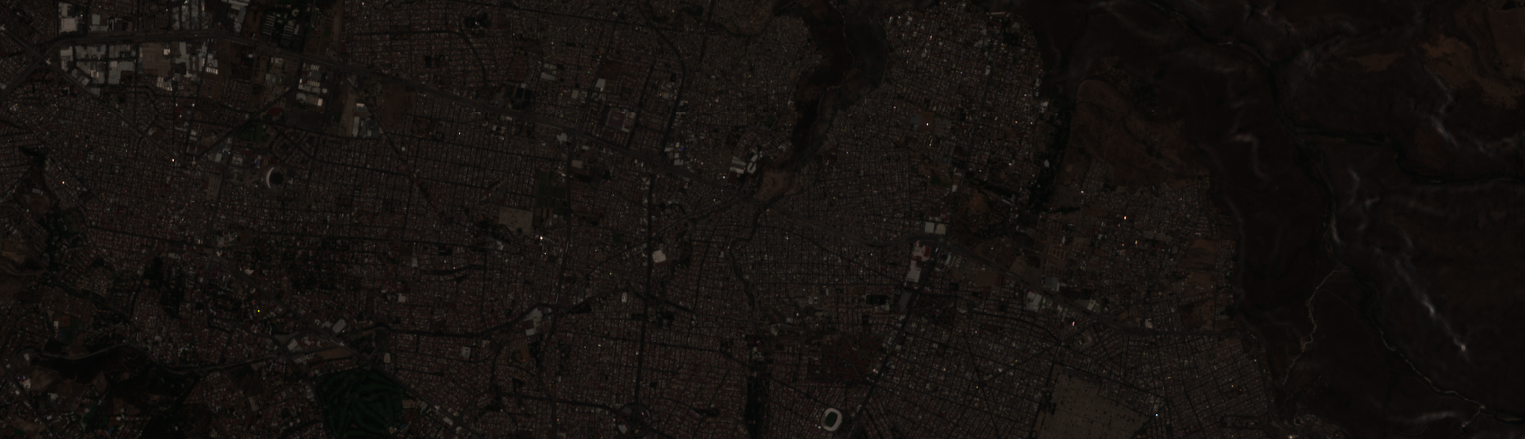

In [20]:
rescaled = multiband_data.astype(float)
min_value, max_value = rescaled.min(), rescaled.max()
rescaled = ((rescaled - min_value) * 255) / (max_value - min_value)
byte_data = rescaled.astype("ubyte")
Image.fromarray(np.transpose(byte_data, axes=[1, 2, 0]))

In [36]:
g = raster_to_poly(pc.sign(find_asset_by_band_common_name(selected_item, "green").href))
nir = raster_to_poly(pc.sign(find_asset_by_band_common_name(selected_item, "nir").href))

In [37]:
print(g.shape)
g.head(2)

(38544, 2)


,geometry,data
0,POINT (600005.000 2300035.000),619
1,POINT (600015.000 2300035.000),632


In [38]:
print(nir.shape)
nir.head(2)

(38544, 2)


,geometry,data
0,POINT (600005.000 2300035.000),3670
1,POINT (600015.000 2300035.000),3758


In [39]:
ndvi_df = g.merge(nir[['data']], left_index=True, right_index=True)
ndvi_df.rename(columns={'data_x':'g','data_y':'nir'}, inplace=True)
print(ndvi_df.shape)
ndvi_df.head(2)

(38544, 3)


,geometry,g,nir
0,POINT (600005.000 2300035.000),619,3670
1,POINT (600015.000 2300035.000),632,3758


In [40]:
ndvi_df['ndvi'] = (ndvi_df['nir']-ndvi_df['g'])/(ndvi_df['nir']+ndvi_df['g'])

In [41]:
ndvi_df.head(5)

,geometry,g,nir,ndvi
0,POINT (600005.000 2300035.000),619,3670,0.711355
1,POINT (600015.000 2300035.000),632,3758,0.712073
2,POINT (600025.000 2300035.000),628,3670,0.707771
3,POINT (600035.000 2300035.000),573,3400,0.711553
4,POINT (600045.000 2300035.000),588,3360,0.702128


In [42]:
g = read_band(
    pc.sign(find_asset_by_band_common_name(selected_item, "green").href)
).astype(float)

nir = read_band(
    pc.sign(find_asset_by_band_common_name(selected_item, "nir").href)
).astype(float)

ndvi = (nir - g) / (nir + g)
w = ndvi.shape[0]
h = ndvi.shape[1]

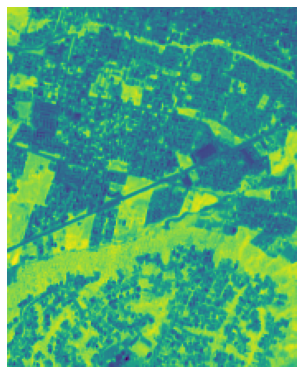

In [43]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

dpi = 150
fig = figure(figsize=(5,5), frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(ndvi, cmap="viridis")
#plt.legend(ndvi)

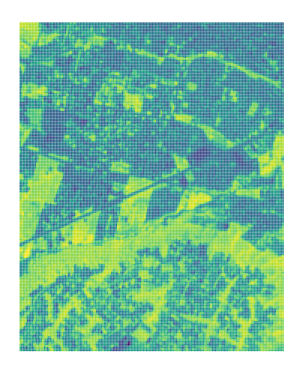

In [54]:
dpi = 150
fig = figure(figsize=(5,5), frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

ndvi_df.plot('ndvi', s=0.5, ax=ax)
#plt.imshow(ndvi, cmap="viridis")

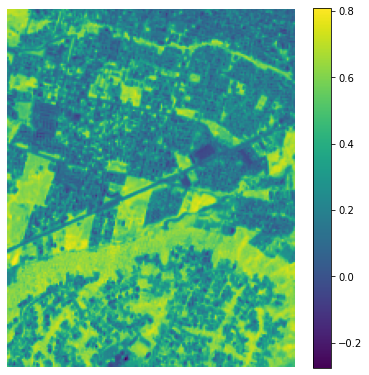

In [34]:
import matplotlib as mpl

dpi = 150
fig = figure(figsize=(5,5), frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(ndvi, cmap="viridis")


#Sets boundaries for color ramp
bounds = [-0.3, 0.0,0.6]

#Gets axes
cax, kw = mpl.colorbar.make_axes(plt.gca())

#Normalizes values of color ramp
norm = mpl.colors.Normalize(vmin = ndvi.min(), vmax = ndvi.max(), clip = False)

#Draws color bar with color ramp legend
mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.viridis, norm=norm)

In [24]:
ndvi.mean()

0.27532999031752003

In [25]:
ndvi.max()

0.8229271230676571

In [26]:
ndvi.min()

-0.41098415038702546

In [27]:
ndvi_2 = ndvi.copy()
ndvi_2[ndvi<=0.1] = np.nan

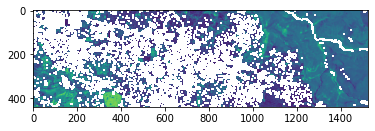

In [28]:
plt.imshow(ndvi_2, cmap="viridis")

In [29]:
ndvi

array([[0.21248499, 0.21004566, 0.20357706, ..., 0.28126497, 0.30071174,
        0.30762411],
       [0.18960425, 0.20921771, 0.19915478, ..., 0.31520285, 0.30694811,
        0.29384544],
       [0.20930233, 0.2116129 , 0.24471299, ..., 0.29369369, 0.3038674 ,
        0.27759197],
       ...,
       [0.36127965, 0.34601542, 0.33091662, ..., 0.29248658, 0.27609428,
        0.26876702],
       [0.35732648, 0.27272727, 0.37423313, ..., 0.28254955, 0.25939992,
        0.25994318],
       [0.29907773, 0.34414081, 0.51997597, ..., 0.3037037 , 0.25180897,
        0.24779362]])

In [30]:
ndvi.shape

(439, 1525)

In [104]:
import rasterio
from rasterio.features import shapes

In [105]:
mask = None
with rasterio.Env():
        image = ndvi.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [108]:
multiband_data.shape

(3, 439, 1525)

In [25]:
import rasterio
from rasterio.features import shapes
mask = None
with rasterio.Env():
    with rasterio.open(signed_hrefs[0]) as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))

In [ ]:
geoms = list(results)

In [ ]:
geoms.plot()